In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
from tensorflow import keras
from tensorflow.keras import activations
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras import utils

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [4]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 2500
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [6]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [8]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

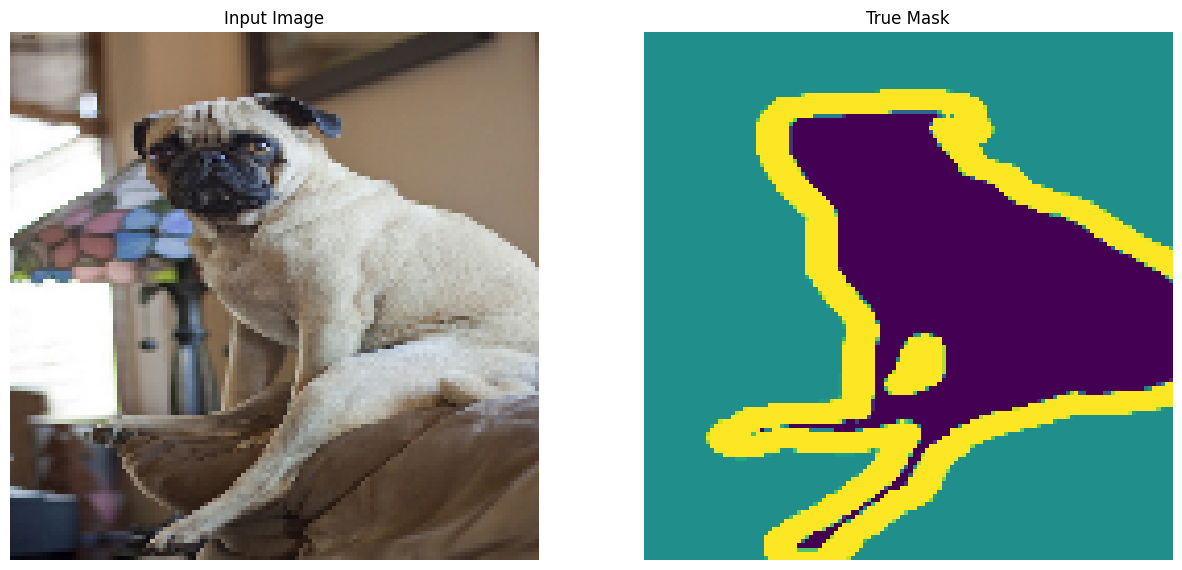

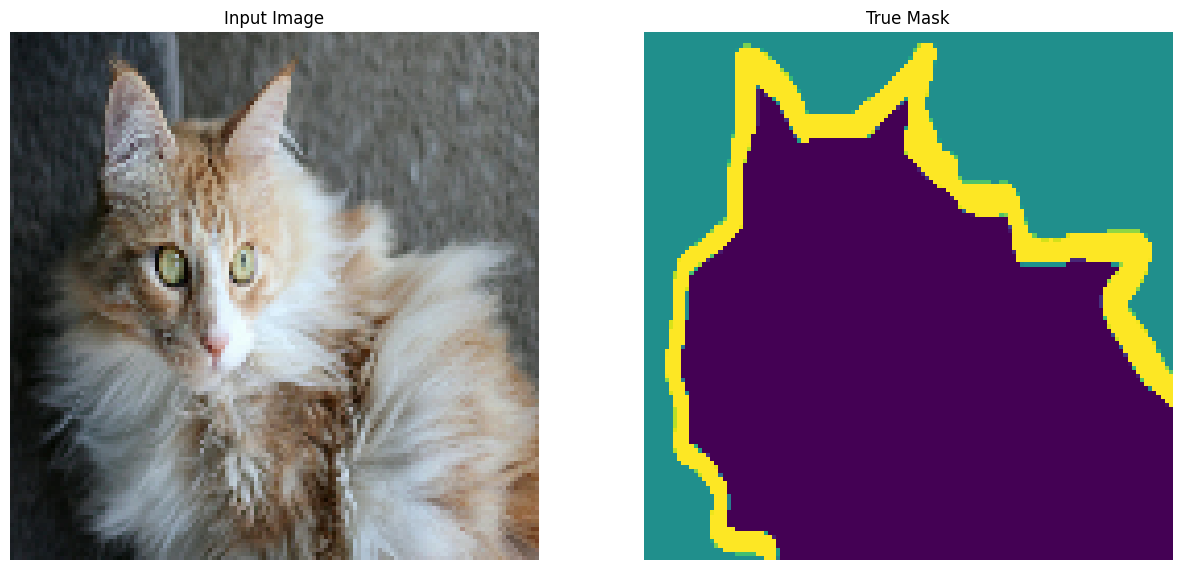

In [10]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [11]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [12]:
inp = Input(shape=(128, 128, 3))

conv_1_1 = Conv2D(32, (3,3), padding = 'same', activation='relu')(inp)
conv_1_2 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conv_1_1)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(32, (3,3), padding = 'same', activation='relu')(pool_1)
conv_2_2 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conv_2_1)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(64, (3,3), padding = 'same', activation='relu')(pool_2)
conv_3_2 = Conv2D(64, (3,3), padding = 'same', activation='relu')(conv_3_1)


pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(128, (3,3), padding = 'same', activation='relu')(pool_3)
conv_4_2 = Conv2D(128, (3,3), padding = 'same', activation='relu')(conv_4_1)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = keras.layers.Concatenate()([conv_4_2, up_1])
conv_up_1_1 = Conv2D(128, (3,3), padding = 'same', activation='relu')(conc_1)
conv_up_1_2 = Conv2D(128, (3,3), padding = 'same', activation='relu')(conv_up_1_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = keras.layers.Concatenate()([conv_3_2, up_2])
conv_up_2_1 = Conv2D(64, (3,3), padding = 'same', activation='relu')(conc_2)
conv_up_2_2 = Conv2D(64, (3,3), padding = 'same', activation='relu')(conv_up_2_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = keras.layers.Concatenate()([conv_2_2, up_3])
conv_up_3_1 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conc_3)
conv_up_3_2 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conv_up_3_1)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = keras.layers.Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conc_4)
conv_up_4_2 = Conv2D(3, (3,3), padding = 'same', activation='sigmoid')(conv_up_4_1)

model = Model(inputs = inp, outputs = conv_up_4_2)

In [13]:
#print(conv_up_4_3.shape[1:])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [17]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 16ms/step


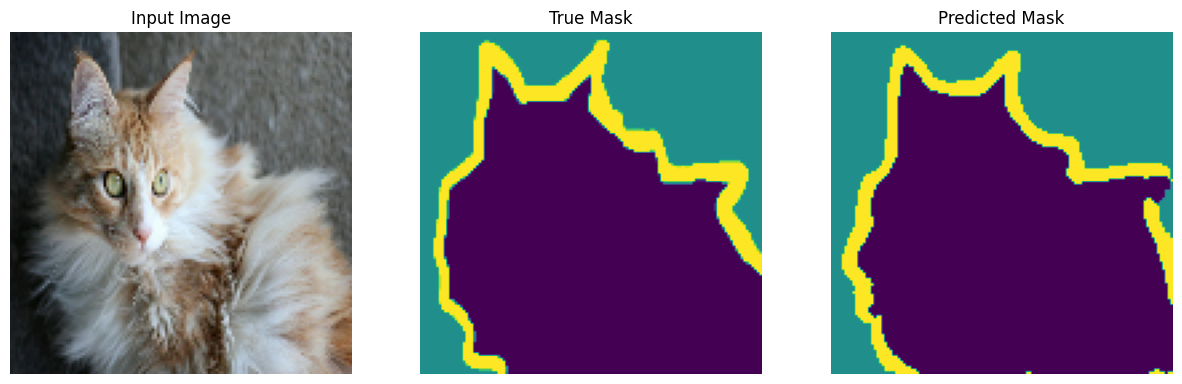


Sample Prediction after epoch 33

57/57 [==============================] - 8s 137ms/step - loss: 0.1949 - accuracy: 0.9145 - val_loss: 0.4097 - val_accuracy: 0.8620
Epoch 34/35
19/57 [=========>....................] - ETA: 4s - loss: 0.1885 - accuracy: 0.9170

In [ ]:
EPOCHS = 35
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
#model.save("segmentation_by_hands_model.h5")